In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv
from pandas import DataFrame

from numpy import dstack

import copy

import os
from glob import glob

from path import Path

from numpy import mean
from numpy import std

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Input
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import SimpleRNN
from keras.models import Model

from keras.layers import Bidirectional

from keras.layers.merge import concatenate

from keras.utils.vis_utils import plot_model

from keras.callbacks import EarlyStopping

from keras.optimizers import Adam

import keras.backend as K

import random

from sklearn.model_selection import train_test_split

from matplotlib import pyplot

Using TensorFlow backend.


## Load Data

In [2]:
from helpers.classes.data_loader import DataLoader

In [3]:
%%time
root_path = "/home/ubuntu/pose-estimation-jupyter/augmented-keypoints-339"

sample_dir_names = [n for n in os.listdir(root_path) if os.path.isdir(f"{root_path}/{n}")]

samples = DataLoader.get_samples_list(sample_dir_names, root_path)

y_labels = DataLoader.get_y_labels(sample_dir_names) # classifier labels, where 0 = backflip and 1 = flack

Loading frames for 0/339
Loading frames for 1/339
Loading frames for 2/339
Loading frames for 3/339
Loading frames for 4/339
Loading frames for 5/339
Loading frames for 6/339
Loading frames for 7/339
Loading frames for 8/339
Loading frames for 9/339
Loading frames for 10/339
Loading frames for 11/339
Loading frames for 12/339
Loading frames for 13/339
Loading frames for 14/339
Loading frames for 15/339
Loading frames for 16/339
Loading frames for 17/339
Loading frames for 18/339
Loading frames for 19/339
Loading frames for 20/339
Loading frames for 21/339
Loading frames for 22/339
Loading frames for 23/339
Loading frames for 24/339
Loading frames for 25/339
Loading frames for 26/339
Loading frames for 27/339
Loading frames for 28/339
Loading frames for 29/339
Loading frames for 30/339
Loading frames for 31/339
Loading frames for 32/339
Loading frames for 33/339
Loading frames for 34/339
Loading frames for 35/339
Loading frames for 36/339
Loading frames for 37/339
Loading frames for 38/

Loading frames for 308/339
Loading frames for 309/339
Loading frames for 310/339
Loading frames for 311/339
Loading frames for 312/339
Loading frames for 313/339
Loading frames for 314/339
Loading frames for 315/339
Loading frames for 316/339
Loading frames for 317/339
Loading frames for 318/339
Loading frames for 319/339
Loading frames for 320/339
Loading frames for 321/339
Loading frames for 322/339
Loading frames for 323/339
Loading frames for 324/339
Loading frames for 325/339
Loading frames for 326/339
Loading frames for 327/339
Loading frames for 328/339
Loading frames for 329/339
Loading frames for 330/339
Loading frames for 331/339
Loading frames for 332/339
Loading frames for 333/339
Loading frames for 334/339
Loading frames for 335/339
Loading frames for 336/339
Loading frames for 337/339
Loading frames for 338/339
CPU times: user 1min 10s, sys: 869 ms, total: 1min 11s
Wall time: 1min 10s


In [4]:
i = 5

# Print some sample dir names
a = [print(sample_dir_name) for sdn_i, sample_dir_name in enumerate(sample_dir_names) if sdn_i < i]
a = [print(y_label) for y_i, y_label in enumerate(y_labels) if y_i < i]

backflip-33-mario-aug-2
backflip-46-dagne-aug-1
backflip-63-allar-aug-1
backflip-47-dagne-aug-1
flack-56-martin-aug-0
0
0
0
0
1


## Data padding

In [5]:
from helpers.classes.padder import Padder

In [6]:
%%time
padded_samples_list = Padder.get_padded_samples(samples)
categorical_y_labels = DataLoader.get_categorical_y_labels(y_labels)

padded_samples_ndarray = np.asarray(padded_samples_list)
categorical_y_labels_ndarray = np.asarray(categorical_y_labels)

y_labels_stacked shape: (1, 1, 339)
y_labels_categorical shape: (1, 1, 339, 2)
y_labels_squeezed shape (339, 2)
y_label categorical: [1.0, 0.0]
y_label categorical: [1.0, 0.0]
y_label categorical: [1.0, 0.0]
y_label categorical: [1.0, 0.0]
y_label categorical: [0.0, 1.0]
CPU times: user 3.45 s, sys: 7.97 ms, total: 3.45 s
Wall time: 3.44 s


## Split data

In [7]:
r_arm_keypoints = [2, 3, 4]
l_arm_keypoints = [5, 6, 7]
trunk_keypoints = [0, 1, 8]
r_leg_keypoints = [9, 10, 11]
l_leg_keypoints = [12, 13, 14]

def get_xy_keypoints(keypoints, max_keypoints=30):
    to_add = max_keypoints / 2
    
    xy_pairs = [(kp, int(kp + to_add)) for kp in keypoints]
    
    xy_keypoints = [item for sublist in xy_pairs for item in sublist] # flatten
    
    return xy_keypoints
    
def get_bodypart_padded_samples_ndarray(padded_samples_ndarray, keypoints):
    xy_keypoints = get_xy_keypoints(r_arm_keypoints)
        
    return padded_samples_ndarray[:, :, xy_keypoints]
    
r_arm_ndarray = get_bodypart_padded_samples_ndarray(padded_samples_ndarray, r_arm_keypoints)
l_arm_ndarray = get_bodypart_padded_samples_ndarray(padded_samples_ndarray, l_arm_keypoints)
trunk_ndarray = get_bodypart_padded_samples_ndarray(padded_samples_ndarray, trunk_keypoints)
r_leg_ndarray = get_bodypart_padded_samples_ndarray(padded_samples_ndarray, r_leg_keypoints)
l_leg_ndarray = get_bodypart_padded_samples_ndarray(padded_samples_ndarray, l_leg_keypoints)

In [8]:
r_arm_X_train, r_arm_X_test, y_train, y_test = train_test_split(r_arm_ndarray,
                                                    categorical_y_labels_ndarray,
                                                    test_size=0.2,
                                                    random_state=42)

l_arm_X_train, l_arm_X_test, y_train, y_test = train_test_split(l_arm_ndarray,
                                                    categorical_y_labels_ndarray,
                                                    test_size=0.2,
                                                    random_state=42)

trunk_X_train, trunk_X_test, y_train, y_test = train_test_split(trunk_ndarray,
                                                    categorical_y_labels_ndarray,
                                                    test_size=0.2,
                                                    random_state=42)

r_leg_X_train, r_leg_X_test, y_train, y_test = train_test_split(r_leg_ndarray,
                                                    categorical_y_labels_ndarray,
                                                    test_size=0.2,
                                                    random_state=42)

l_leg_X_train, l_leg_X_test, y_train, y_test = train_test_split(l_leg_ndarray,
                                                    categorical_y_labels_ndarray,
                                                    test_size=0.2,
                                                    random_state=42)


print(f"trunk_X_train shape: {trunk_X_train.shape}")
print(f"X train len: {len(trunk_X_train)}, y train len:{len(y_train)} --- X test len:{len(trunk_X_test)}, y test len:{len(y_test)}")

trunk_X_train shape: (271, 110, 6)
X train len: 271, y train len:271 --- X test len:68, y test len:68


## Build model

In [10]:
def get_simple_rnn_model(lstm_units, n_outputs, n_features, n_timesteps):
    optimizer = Adam(lr=0.001)
    
    input_shape = (n_timesteps, n_features)
    print(f"Model input shape {input_shape}")
    
    # R arm
    model1_in = Input(shape=input_shape)
    r_arm_out = SimpleRNN(lstm_units, return_sequences=True, input_shape=input_shape, name="r_arm_layer")(model1_in)

    # L arm
    model2_in = Input(shape=input_shape)
    l_arm_out = SimpleRNN(lstm_units, return_sequences=True, input_shape=input_shape, name="l_arm_layer")(model2_in)
    
    # trunk
    model3_in = Input(shape=input_shape)
    trunk_out = SimpleRNN(lstm_units, return_sequences=True, input_shape=input_shape, name="trunk_layer")(model3_in)
    
    # R leg
    model4_in = Input(shape=input_shape)
    r_leg_out = SimpleRNN(lstm_units, return_sequences=True, input_shape=input_shape, name="r_leg_layer")(model4_in)
    
    # L leg
    model5_in = Input(shape=input_shape)
    l_leg_out = SimpleRNN(lstm_units, return_sequences=True, input_shape=input_shape, name="l_leg_layer")(model5_in)
    
    # First merge layer
    r_arm_trunk_layer = concatenate([r_arm_out, trunk_out], name="r_arm_trunk_layer")
    
    l_arm_trunk_layer = concatenate([l_arm_out, trunk_out], name="l_arm_trunk_layer")
    
    r_leg_trunk_layer = concatenate([r_leg_out, trunk_out], name="r_leg_trunk_layer")
    
    l_leg_trunk_layer = concatenate([l_leg_out, trunk_out], name="l_leg_trunk_layer")
    
    # Second merge layer
    
    upper_body_layer = concatenate([r_arm_trunk_layer, l_arm_trunk_layer], name="upper_body_layer")
    
    lower_body_layer = concatenate([r_leg_trunk_layer, l_leg_trunk_layer], name="lower_body_layer")
    
    # Third merge layer
    
    full_body_layer = concatenate([upper_body_layer, lower_body_layer], name="full_body_layer")
    
    dropout_layer = Dropout(0.8)(full_body_layer)
    
    activation_layer = Dense(lstm_units, activation='relu', name="relu_layer")(dropout_layer)
    
    flatten_layer = Flatten()(activation_layer)
        
    output_layer = Dense(n_outputs, activation='softmax', name="softmax_layer")(flatten_layer)

    model = Model([model1_in, model2_in, model3_in, model4_in, model5_in], output_layer)
    
    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])
    
    return model

def evaluate_model(trainXs, trainy, testXs, testy):
    verbose, epochs = 1, 5
    
    #n_steps_per_epoch = 360
    
    lstm_units = 2

    n_timesteps, n_features, n_outputs = trainXs[0].shape[1], trainXs[0].shape[2], trainy.shape[1]
    
    model = get_simple_rnn_model(lstm_units, n_outputs, n_features, n_timesteps)
    
    print(model.summary())
    
    batch_size = 1
    
    es_callback = EarlyStopping(monitor='val_loss',
                                patience=3)
    
    history = model.fit(trainXs,
                        trainy,
                        epochs=epochs,
                        batch_size=batch_size,
                        verbose=verbose,
                        validation_split=0.33,
                        #callbacks=[es_callback]
                       )
    # evaluate model
    _, accuracy = model.evaluate(testXs, testy, batch_size=batch_size, verbose=0)
    
    # fit network
    #model.fit_generator(train_generator(trainX, trainy), steps_per_epoch=n_steps_per_epoch, epochs=epochs, verbose=verbose)
    # evaluate model
    #_, accuracy = model.evaluate_generator(train_generator(testX, testy), steps=len(testX), verbose=0)
    
    return history, accuracy, model

In [11]:
def summarize_results(scores):
    print(scores)
    m, s = mean(scores), std(scores)
    print('Accuracy: %.3f%% (+/-%.3f)' % (m, s))

In [12]:
def save_model(model, repeat):
    # serialize model to JSON
    model_json = model.to_json()
    with open(f"model-{repeat}.json", "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights(f"model-{repeat}.h5")
    
    plot_model(model, to_file=f"model-plot-{repeat}.png", show_shapes=True, show_layer_names=True)
    
    print("Saved model to disk")

## Run experiment

In [13]:
train_loss_history = DataFrame()
val_loss_history = DataFrame()

train_accuracy_history = DataFrame()
val_accuracy_history = DataFrame()

model_history = []

# run an experiment
def run_experiment(repeats=5):
    # repeat experiment
    scores = list()
    last_history = None
    
    for r in range(repeats):
        history, score, model = evaluate_model([r_arm_X_train, l_arm_X_train, trunk_X_train, r_leg_X_train, l_leg_X_train],
                                               y_train,
                                               [r_arm_X_test, l_arm_X_test, trunk_X_test, r_leg_X_test, l_leg_X_test],
                                               y_test)
        
        model_history.append(model)
        save_model(model, r)
        
        # story history
        train_loss_history[str(r)] = history.history['loss']
        val_loss_history[str(r)] = history.history['val_loss']
        train_accuracy_history[str(r)] = history.history['accuracy']
        val_accuracy_history[str(r)] = history.history['val_accuracy']
        
        score = score * 100.0
        print('>#%d validation accuracy: %.3f' % (r+1, score))
        scores.append(score)
        
    # summarize results
    summarize_results(scores)
    


In [14]:
%%time
run_experiment()

Model input shape (110, 6)
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 110, 6)       0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 110, 6)       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 110, 6)       0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 110, 6)       0                                            
_________________________________________________________________

Train on 181 samples, validate on 90 samples
Epoch 1/5
181/181 [==============================] - 45s 247ms/step - loss: 1.3722 - accuracy: 0.5304 - val_loss: 0.4902 - val_accuracy: 0.7667
Epoch 2/5
181/181 [==============================] - 44s 242ms/step - loss: 0.7512 - accuracy: 0.6796 - val_loss: 0.2389 - val_accuracy: 0.9667
Epoch 3/5
181/181 [==============================] - 44s 245ms/step - loss: 0.4299 - accuracy: 0.8177 - val_loss: 0.0686 - val_accuracy: 1.0000
Epoch 4/5
181/181 [==============================] - 44s 243ms/step - loss: 0.2077 - accuracy: 0.9061 - val_loss: 0.0208 - val_accuracy: 1.0000
Epoch 5/5
181/181 [==============================] - 44s 245ms/step - loss: 0.1277 - accuracy: 0.9613 - val_loss: 0.0068 - val_accuracy: 1.0000
Saved model to disk
>#2 validation accuracy: 100.000
Model input shape (110, 6)
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output 

Train on 181 samples, validate on 90 samples
Epoch 1/5
181/181 [==============================] - 45s 246ms/step - loss: 0.9228 - accuracy: 0.6133 - val_loss: 0.3804 - val_accuracy: 0.8333
Epoch 2/5
181/181 [==============================] - 44s 245ms/step - loss: 0.5978 - accuracy: 0.7072 - val_loss: 0.3392 - val_accuracy: 0.8444
Epoch 3/5
181/181 [==============================] - 43s 240ms/step - loss: 0.3847 - accuracy: 0.8011 - val_loss: 0.3069 - val_accuracy: 0.8889
Epoch 4/5
181/181 [==============================] - 43s 240ms/step - loss: 0.2760 - accuracy: 0.8840 - val_loss: 0.2969 - val_accuracy: 0.9111
Epoch 5/5
181/181 [==============================] - 44s 241ms/step - loss: 0.2266 - accuracy: 0.9116 - val_loss: 0.2542 - val_accuracy: 0.9778
Saved model to disk
>#4 validation accuracy: 92.647
Model input shape (110, 6)
Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output S

## Plots

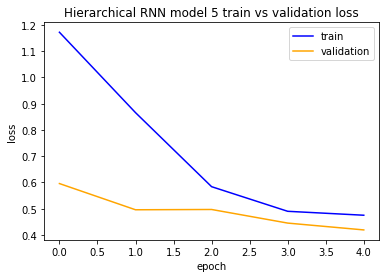

In [23]:
model_num = '4'
model_num_for_fig = int(model_num) + 1

pyplot.plot(train_loss_history[model_num], color='blue', label='train')
pyplot.plot(val_loss_history[model_num], color='orange', label='validation')
pyplot.title(f"Hierarchical RNN model {model_num_for_fig} train vs validation loss")
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper right')
#pyplot.show()

fig_name = f"model-output/model-{model_num_for_fig}-train-vs-validation-loss.png"
pyplot.savefig(fig_name)

In [ ]:
pyplot.plot(train_accuracy_history[model_num], color='blue', label='train')
pyplot.plot(val_accuracy_history[model_num], color='orange', label='validation')
pyplot.title(f"Hierarchical RNN model {model_num_for_fig} train vs validation accuracy")
pyplot.ylabel('accuracy')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper right')
#pyplot.show()

fig_name = f"model-output/model-{model_num_for_fig}-train-vs-validation-accuracy.png"
pyplot.savefig(fig_name)

## Sample

In [16]:
example_sample_idx = 40
model_history_idx = 4

#example_sample_dir_name = sample_dir_names[example_sample_idx]
example_sample = r_arm_X_train[example_sample_idx]
example_model = model_history[model_history_idx]

## Predictions

In [17]:
def predictions(loaded_model, samples, sample_dir_names, y_labels):
    ynew = loaded_model.predict(samples)
        
    ynew = np.argmax(ynew,axis=1)
    y_labels = np.argmax(y_labels,axis=1)
    
    print(ynew)

    # show the inputs and predicted outputs
    for i in range(len(samples[0])):
        pred_y = ynew[i]
        actual_y = y_labels[i]
    
        same = False
        if pred_y == actual_y:
            same = True
    
        print("Name=%s, X=%s, Predicted=%s, Actual=%s, same=%s" % (sample_dir_names[i], i, pred_y, actual_y, same))
    
predictions(example_model, [r_arm_X_test, l_arm_X_test, trunk_X_test, r_leg_X_test, l_leg_X_test], sample_dir_names, y_test)

[1 0 1 ... 0 1 0]
Name=backflip-51-rasmus-aug-3, X=0, Predicted=1, Actual=1, same=True
Name=flack-9-hendrik-aug-40, X=1, Predicted=0, Actual=0, same=True
Name=flack-49-kristiin-aug-30, X=2, Predicted=1, Actual=1, same=True
Name=backflip-52-rasmus-aug-44, X=3, Predicted=1, Actual=1, same=True
Name=flack-9-hendrik-aug-14, X=4, Predicted=1, Actual=1, same=True
Name=backflip-46-dagne-aug-18, X=5, Predicted=0, Actual=0, same=True
Name=backflip-31-hendrik-aug-83, X=6, Predicted=1, Actual=1, same=True
Name=backflip-56-margus-aug-41, X=7, Predicted=0, Actual=0, same=True
Name=backflip-53-rasmus-aug-52, X=8, Predicted=0, Actual=0, same=True
Name=flack-67-rasmus-aug-28, X=9, Predicted=1, Actual=1, same=True
Name=flack-30-rasmus-aug-76, X=10, Predicted=1, Actual=1, same=True
Name=flack-30-rasmus-aug-44, X=11, Predicted=0, Actual=0, same=True
Name=backflip-37-mario-aug-25, X=12, Predicted=0, Actual=0, same=True
Name=backflip-31-hendrik-aug-93, X=13, Predicted=0, Actual=0, same=True
Name=backflip-5

Name=flack-12-rasmus-aug-28, X=2503, Predicted=0, Actual=0, same=True
Name=backflip-9-hendrik-aug-21, X=2504, Predicted=1, Actual=1, same=True
Name=backflip-48-joosep-aug-99, X=2505, Predicted=0, Actual=0, same=True
Name=flack-48-kristiin-aug-69, X=2506, Predicted=0, Actual=0, same=True
Name=flack-55-martin-aug-11, X=2507, Predicted=1, Actual=1, same=True
Name=flack-39-margus-aug-11, X=2508, Predicted=0, Actual=0, same=True
Name=backflip-64-allar-aug-22, X=2509, Predicted=0, Actual=0, same=True
Name=flack-30-rasmus-aug-40, X=2510, Predicted=0, Actual=0, same=True
Name=flack-28-julia-aug-87, X=2511, Predicted=0, Actual=0, same=True
Name=backflip-2-allar-aug-67, X=2512, Predicted=0, Actual=0, same=True
Name=flack-37-hendrik-aug-44, X=2513, Predicted=0, Actual=0, same=True
Name=flack-78-martin-aug-93, X=2514, Predicted=0, Actual=0, same=True
Name=flack-12-rasmus-aug-67, X=2515, Predicted=1, Actual=1, same=True
Name=backflip-61-hendrik-aug-88, X=2516, Predicted=1, Actual=1, same=True
Name=

Name=backflip-53-rasmus-aug-55, X=5023, Predicted=0, Actual=0, same=True
Name=flack-37-hendrik-aug-92, X=5024, Predicted=1, Actual=1, same=True
Name=backflip-45-kristjan-aug-30, X=5025, Predicted=1, Actual=1, same=True
Name=flack-17-rasmus-aug-33, X=5026, Predicted=1, Actual=1, same=True
Name=backflip-31-hendrik-aug-8, X=5027, Predicted=0, Actual=0, same=True
Name=backflip-61-hendrik-aug-86, X=5028, Predicted=0, Actual=0, same=True
Name=flack-24-belinda-aug-55, X=5029, Predicted=0, Actual=0, same=True
Name=backflip-25-tiit-aug-40, X=5030, Predicted=1, Actual=1, same=True
Name=flack-25-margus-aug-47, X=5031, Predicted=1, Actual=1, same=True
Name=backflip-20-martin-aug-59, X=5032, Predicted=1, Actual=1, same=True
Name=backflip-49-joosep-aug-56, X=5033, Predicted=1, Actual=1, same=True
Name=backflip-60-hendrik-aug-31, X=5034, Predicted=0, Actual=0, same=True
Name=flack-4-martin-aug-99, X=5035, Predicted=0, Actual=0, same=True
Name=backflip-36-mario-aug-6, X=5036, Predicted=1, Actual=1, sa

Name=flack-4-martin-aug-85, X=7508, Predicted=0, Actual=0, same=True
Name=backflip-55-rasmus-aug-48, X=7509, Predicted=0, Actual=0, same=True
Name=flack-59-martin-aug-45, X=7510, Predicted=0, Actual=0, same=True
Name=flack-24-belinda-aug-7, X=7511, Predicted=1, Actual=1, same=True
Name=flack-38-hendrik-aug-21, X=7512, Predicted=0, Actual=0, same=True
Name=backflip-45-kristjan-aug-41, X=7513, Predicted=0, Actual=0, same=True
Name=flack-63-rasmus-aug-77, X=7514, Predicted=0, Actual=0, same=True
Name=backflip-49-joosep-aug-27, X=7515, Predicted=0, Actual=0, same=True
Name=flack-58-martin-aug-99, X=7516, Predicted=1, Actual=1, same=True
Name=flack-78-martin-aug-9, X=7517, Predicted=0, Actual=0, same=True
Name=backflip-40-margus-aug-47, X=7518, Predicted=1, Actual=1, same=True
Name=backflip-1-allar-aug-7, X=7519, Predicted=1, Actual=1, same=True
Name=flack-16-rasmus-aug-37, X=7520, Predicted=0, Actual=0, same=True
Name=backflip-9-hendrik-aug-62, X=7521, Predicted=1, Actual=1, same=True
Name

## Activation

In [18]:
layer_names = [layer.name for layer in example_model.layers]

print(example_sample.shape)
print(layer_names)

def activations(model, example_sample): 
    n_timesteps, n_features = example_sample.shape[0], example_sample.shape[1]
    
    print(f"n_timesteps: {n_timesteps}, n_features: {n_features}")
    
    x = np.zeros((1, n_timesteps, n_features))
    
    for t, timestep in enumerate(example_sample):
        for f, feature in enumerate(timestep):
            x[0, t, f] = example_sample[t][f]
                
    output = model.get_layer('r_arm_layer').output
    
    f = K.function([model.input[0]], [output])
    
    f_result = f([x])
    
    return f_result[0][0]


act = activations(example_model, example_sample)
print(act)
act.shape

(110, 6)
['input_21', 'input_23', 'input_22', 'input_24', 'input_25', 'r_arm_layer', 'trunk_layer', 'l_arm_layer', 'r_leg_layer', 'l_leg_layer', 'r_arm_trunk_layer', 'l_arm_trunk_layer', 'r_leg_trunk_layer', 'l_leg_trunk_layer', 'upper_body_layer', 'lower_body_layer', 'full_body_layer', 'dropout_5', 'relu_layer', 'flatten_5', 'softmax_layer']
n_timesteps: 110, n_features: 6
[[ 1.         -1.        ]
 [ 1.         -1.        ]
 [ 1.         -1.        ]
 [ 1.         -1.        ]
 [ 1.         -1.        ]
 [ 1.         -1.        ]
 [ 1.         -1.        ]
 [ 1.         -1.        ]
 [ 1.         -1.        ]
 [ 1.         -1.        ]
 [ 1.         -1.        ]
 [ 1.         -1.        ]
 [ 1.         -1.        ]
 [ 1.         -1.        ]
 [ 1.         -1.        ]
 [ 1.         -1.        ]
 [ 1.         -1.        ]
 [ 1.          1.        ]
 [ 1.          1.        ]
 [ 1.          1.        ]
 [ 1.          1.        ]
 [ 0.99999815  1.        ]
 [ 0.9073783   1.        ]
 [

(110, 2)

In [19]:
from io import BytesIO
from PIL import Image as PILImage
from PIL import ImageDraw
from IPython.display import Image

def get_image(img, n_timesteps, img_idx, cell_size=48):
    img_width = n_timesteps * 25
    cell_size = int(img_width / n_timesteps)
    
    pil_image = PILImage.fromarray(img.astype(np.uint8))
    
    resized_pil_image = pil_image.resize((img_width, cell_size))
    #resized_pil_image = pil_image
    
    draw = ImageDraw.Draw(resized_pil_image)
    
    for n_timestep in range(n_timesteps):
        text = str((img_idx * 30) + n_timestep)
        xy = (n_timestep * cell_size, 0)
        
        draw.text(xy, text)
        
    f = BytesIO()
    resized_pil_image.save(f, 'png')
    return Image(data=f.getvalue())

def visualize_neurons(act, cell_size=48):
    n_neurons = act.shape[1]
    n_timesteps = act.shape[0]
    
    fill_value = 128
    
    img = np.full((n_neurons + 1, n_timesteps, 3), fill_value)
    
    # add 1 to each value in matrix and then divide by 2
    scores = (act[:, :].T + 1) / 2
    
    img[1:, :, 0] = 255 * (1 - scores)
    img[1:, :, 1] = 255 * scores

    first_hs_img = img[:, :30, :]
    second_hs_img = img[:, 30:60, :]
    third_hs_img = img[:, 60:90, :]
    fourth_hs_img = img[:, 90:, :]
    
    imgs = [first_hs_img,
            second_hs_img,
            third_hs_img,
            fourth_hs_img]
    
    actual_imgs = []
    for i, img in enumerate(imgs):
        n_img_timesteps = img.shape[1]
        
        actual_imgs.append(get_image(img, n_img_timesteps, i))
    
    return actual_imgs

example_sample_imgs = visualize_neurons(act)

for img in example_sample_imgs:
    display(img)